In [34]:
import pandas as pd
from ast import literal_eval
import numpy as np
np.seterr(all="raise")

today = "2019-10-02"

df = pd.read_csv(f"out/{today}-2d-test.csv")
df["shape1"] = df.shape1.apply(literal_eval)
df["shape2"] = df.shape2.apply(literal_eval)
df["total_params1"] = df.shape1.apply(lambda x: x[0] * x[1])
df["total_params2"] = df.shape2.apply(lambda x: x[0] * x[1])
df["n1"] = df.shape1.apply(lambda x: x[0])
df["n2"] = df.shape2.apply(lambda x: x[0])
print(len(df))
df.tail()

273


,shape1,shape2,mode,seed,fft_time,direct_time,total_params1,total_params2,n1,n2
268,"(34, 34)","(10, 10)",full,89,0.000552,0.002472,1156,100,34,10
269,"(34, 34)","(10, 10)",same,89,0.000570,0.001749,1156,100,34,10
270,"(6, 6)","(6, 6)",valid,90,0.000559,0.000020,36,36,6,6
271,"(6, 6)","(6, 6)",full,90,0.000536,0.000082,36,36,6,6
272,"(6, 6)","(6, 6)",same,90,0.000698,0.000044,36,36,6,6


In [35]:
def _prod(iterable):
    r = 1
    for it in iterable:
        r *= it
    return r
    
sum_builtin = sum
def _fftconv_faster(x_shape, h_shape, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    x_size = _prod(x_shape)
    x_ndim = len(x_shape)
    h_size = _prod(h_shape)
    h_ndim = len(h_shape)
    if mode == 'full':
        out_shape = [n + k - 1 for n, k in zip(x_shape, h_shape)]
        big_O_constant = 10963.92823819 if x_ndim == 1 else 8899.1104874
    elif mode == 'same':
        out_shape = x_shape
        oneD_big_O = {True: 7183.41306773, False: 856.78174111}
        big_O_constant = oneD_big_O[h_size <= x_size] if x_ndim == 1 \
                                                      else 34519.21021589
    elif mode == 'valid':
        out_shape = [n - k + 1 for n, k in zip(x_shape, h_shape)]
        big_O_constant = 41954.28006344 if x_ndim == 1 else 66453.24316434
    else:
        raise ValueError('mode is invalid')
    out_shape = [o if o > 0 else -o + 2 for o in out_shape]

    # see whether the Fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    direct_time = (x_size * h_size * _prod(out_shape))
    fft_time = sum_builtin(n * np.log(n) for n in (x_shape + h_shape +
                                               tuple(out_shape)))
    return "fft" if big_O_constant * fft_time < direct_time else "direct"

def estimate_faster_method(row):
    x_shape = row["shape1"]
    h_shape = row["shape2"]
    mode = row["mode"]
    return _fftconv_faster(x_shape, h_shape, mode)

In [36]:
fft_faster = df["fft_time"] < df["direct_time"]
df["faster"] = ""
df.loc[fft_faster, "faster"] = "fft"
df.loc[~fft_faster, "faster"] = "direct"

df["faster_est"] = df.apply(estimate_faster_method, axis=1)

acc = (df.faster == df.faster_est).sum() / len(df)
print(f"Predicted fastest method {100 * acc:0.2f}% of the time")

Predicted fastest method 91.21% of the time


In [37]:
wrong_idx = df.faster != df.faster_est
wrong =  df[wrong_idx].copy()
wrong["ratio"] = wrong.fft_time / wrong.direct_time
idx = wrong.ratio < 1
wrong.loc[idx, "ratio"] = 1 / wrong.loc[idx, "ratio"]
wrong[["mode", "shape1", "shape2", "ratio", "direct_time", "fft_time"]]

,mode,shape1,shape2,ratio,direct_time,fft_time
7,full,"(25, 25)","(3, 3)",2.972505,0.000234,0.000696
23,same,"(4, 4)","(136, 136)",2.904629,0.003471,0.001195
28,full,"(3, 3)","(34, 34)",2.812705,0.000218,0.000612
30,valid,"(130, 130)","(3, 3)",1.107041,0.002519,0.002789
38,same,"(6, 6)","(112, 112)",4.200545,0.004045,0.000963
50,same,"(8, 8)","(38, 38)",1.330577,0.001611,0.001211
59,same,"(4, 4)","(124, 124)",2.007717,0.002357,0.001174
99,valid,"(10, 10)","(27, 27)",1.158488,0.000889,0.001030
101,same,"(10, 10)","(27, 27)",1.917122,0.001423,0.000742
104,same,"(3, 3)","(136, 136)",2.016496,0.002623,0.001301


In [38]:
for _, row in wrong.iterrows():
    n1, n2, ratio = row.n1, row.n2, row.ratio
    msg = f"{n1}, {n2}\t ratio={ratio:0.2f}"
    print(msg)

25, 3	 ratio=2.97
4, 136	 ratio=2.90
3, 34	 ratio=2.81
130, 3	 ratio=1.11
6, 112	 ratio=4.20
8, 38	 ratio=1.33
4, 124	 ratio=2.01
10, 27	 ratio=1.16
10, 27	 ratio=1.92
3, 136	 ratio=2.02
5, 59	 ratio=1.09
5, 353	 ratio=9.38
3, 235	 ratio=3.58
81, 3	 ratio=1.18
4, 348	 ratio=5.27
17, 27	 ratio=1.21
13, 7	 ratio=2.38
3, 32	 ratio=3.01
7, 19	 ratio=1.24
5, 85	 ratio=2.30
48, 4	 ratio=1.28
3, 83	 ratio=1.51
3, 83	 ratio=1.32
34, 29	 ratio=2.31


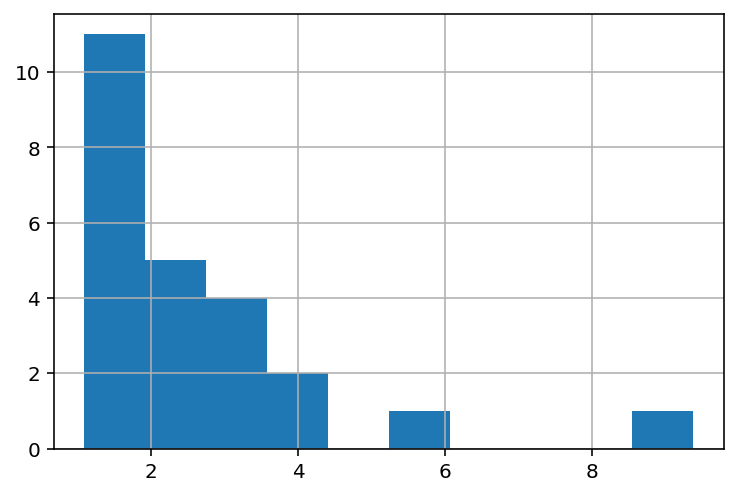

In [39]:
wrong.ratio.hist(bins=10)